In [3]:
import os
import numpy as np
import nbimporter
import matplotlib.pyplot as plt

% matplotlib inline

In [15]:
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from ResNet34 import ResnetBuilder
from DataParserForCNN import read_class, read_full_df, null_augment
from DataParserForCNN import ImageBatchGenerator

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.optimizers import Adam
from keras.metrics import top_k_categorical_accuracy

In [5]:
class_array = read_class()
base_path = '/Volumes/JS/QuickDraw/'

In [6]:
K.set_image_dim_ordering('tf')
resnet34 = ResnetBuilder.build_resnet_34((3, 64, 64), 340)
resnet34.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [8]:
full_df, train_id, valid_id = read_full_df(base_path, class_array)

	 load df   :  339/340                   zigzag   7 min 20 sec

	 load valid_set split:  339/340                   zigzag  10 min 52 sec

In [9]:
print(train_id.shape)
print(valid_id.shape)

(49680379, 3)
(27200, 3)


In [10]:
def normalize(image):
    return image / 255.

train_batch = ImageBatchGenerator(base_path=base_path,
                 class_array=class_array,
                 full_df=full_df,
                 datasplit_id=train_id,
                 split='train_set',
                 batch_size=128, 
                 augment=null_augment, 
                 mode='simplified', 
                 norm=normalize,
                 shuffle=True)

valid_batch = ImageBatchGenerator(base_path=base_path,
                 class_array=class_array,
                 full_df=full_df,
                 datasplit_id=valid_id,
                 split='valid_set',
                 batch_size=128, 
                 augment=null_augment, 
                 mode='simplified', 
                 norm=normalize,
                 shuffle=True)

In [16]:
len(train_batch[0][1])

128

In [17]:
def draw_a_batch(batch_size=16):
    fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))

    for i, ax in enumerate(m_axs.flatten()):
        img = train_batch[0][0][i]
        ax.imshow(img.astype('float'))
        ax.set_title(class_array[np.squeeze(np.where(train_batch[0][1][i] == 1))])

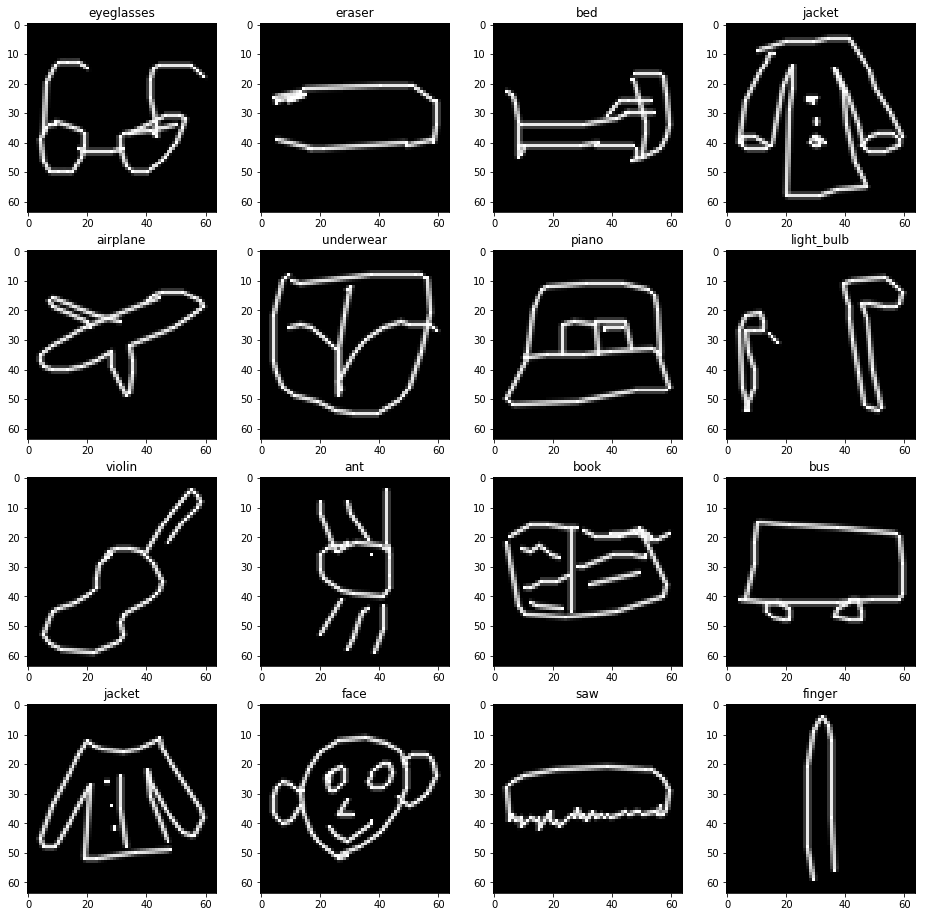

In [18]:
draw_a_batch()

In [19]:
class WeightSaver(Callback):
    def __init__(self, N):
        self.N = N
        self.batch = 0

    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            name = 'qd_rn34_weights%08d.h5' % self.batch
            self.model.save_weights(name)
        self.batch += 1

In [22]:
def top_3_accuracy(x, y): 
    return top_k_categorical_accuracy(x, y, 3)


def train(model):
#     print(model.summary())
    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=0.001,
                               patience=3,
                               mode='min',
                               verbose=1)

    checkpoint = ModelCheckpoint('quick_draw_resnet34_1012.h5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',
                                 period=1)

    reduce_lr = ReduceLROnPlateau(patience=0, factor=0.2, monitor='val_loss', verbose=1)
    weightsaver = WeightSaver(5)  # save weights every 100 steps

    # model.load_weights('./transferLearning_mn_224_0_04425.h5')

    # TODO: try different optimizer and tweak parameters (in MNv1 paper they used RMSprop)
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    # optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
    # optimizer = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy', 
                  metrics = ['categorical_accuracy', top_3_accuracy],
                  optimizer=optimizer)

    model.fit_generator(generator=train_batch,
                        steps_per_epoch=len(train_batch),
                        epochs=20,      # 100
                        verbose=1,
                        validation_data=valid_batch,
                        validation_steps=len(valid_batch),
                        callbacks=[early_stop, checkpoint, reduce_lr, weightsaver],
                        max_queue_size=3)

In [23]:
train(resnet34)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

Epoch 1/20
     7/388128 [..............................] - ETA: 1172:45:32 - loss: 7.7489 - categorical_accuracy: 0.0033 - top_3_accuracy: 0.0112

KeyboardInterrupt: 